In [38]:
import open3d
import numpy as np
import util
import matplotlib.pyplot as plt
import math

**1. Optimization**: You are given the function:  exp(a * x) * sin(x) + b. Implement Levenberg Marquadt using numpy and solve for the parameters of the above function. Optimize for the following parameters: a=2, b = 1. Do this for 50 observations that lie between 1 and 20. Plot the loss values over time and data fit curves. Ensure that your initial estimates are not very close to the final parameters. Write down the jacobian formula in the notebook. **\[3 points\]**

In [19]:
def get_Jr(y_exp,x,a,b):
    da = -(x*np.exp(-a*x))*np.sin(x)
    db = np.ones(np.shape(x))
    Jr = np.array([da,db]).T
    return Jr

def get_residue(y,y_o):
    return y-y_o



1.9999954421463435 1.0000000030415297


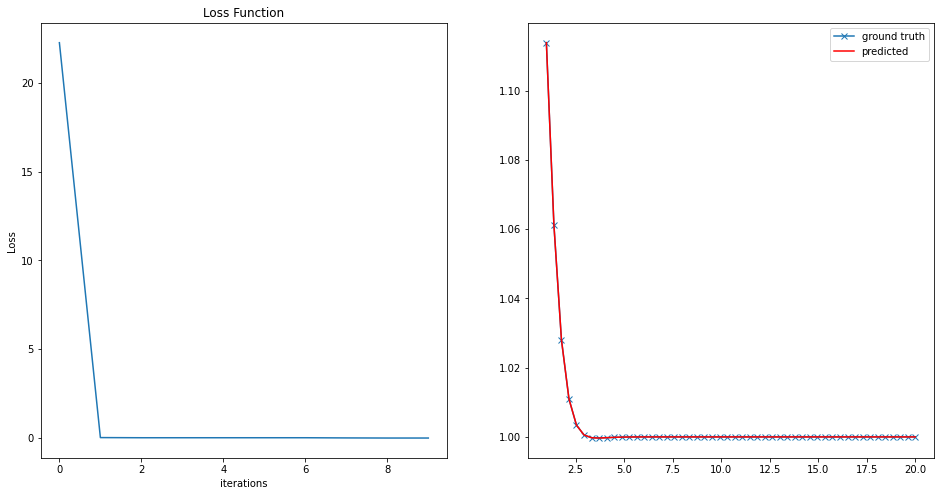

In [27]:
num_obs = 50
a_gt ,b_gt = 2,1
x_o = np.linspace(1,20,num_obs)
y_o = np.exp(-a_gt*x_o)*np.sin(x_o) + b_gt


epoch =10

a,b = np.random.random()*10,np.random.random()
cost = []

identity = np.eye(2,2)
Lambda = 1

for i in range(epoch):
    
    y = np.exp(-a*x_o)*np.sin(x_o) + b
    
    Jr = get_Jr(y,x_o,a,b)
    r  = get_residue(y,y_o)
    
    Jf = np.matmul(np.matmul(np.linalg.pinv(np.matmul(Jr.T,Jr)+Lambda*identity),Jr.T),r)
    
    dk = -Jf
    
    a_prev,b_prev = a,b
    
    a,b = a+dk[0],b+dk[1]
    
    cost.append(np.sum(r**2))

    if i == 0:
        continue
    
    if cost[i] > cost[i-1]:
        a,m,s = a_prev,m_prev,s_prev
        Lambda = Lambda*10
    else:
        Lambda = Lambda*0.1
        
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(cost)
plt.title('Loss Function')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(x_o,make_y(x_o,a,b),marker="x")
plt.plot(x_o,y_o,color="r")
plt.legend(["ground truth","predicted"])
print(a,b)

**2. Linear least square**: You are given a bin file from the Kitti raw sequence. Estimate the ground plane from the given bin file. After estimating the ground plane, visualize this in open3d by drawing 200-300 points on the ground with a different color on top of the plot obtained from the LiDAR scan. Use RANSAC to estimate the ground plane. Will this work without RANSAC? Why or Why not? Write down the equation of the ground plane obtained and also mention the parameters used for doing RANSAC  **\[6 points\]**

Expected result is displayed here:

![output](./data/groundplane.png)

In [53]:
def read_bin_file(file_name):
    '''
    Read the bin file
    '''
    points = np.fromfile(file_name, dtype=np.float32).reshape(-1, 4)
    points = points[:,:3]                # exclude reflectance values, becomes [X Y Z]
    points = points[1::5,:]              # remove every 5th point for display speed (optional)
    return points

In [54]:
filename = "./data/000013.bin"
points = read_bin_file(filename)

# Function used to visualize point clouds, takes a list of 3 x N numpy array as input and plots
util.visualize_pointclouds([points.T])

In [93]:
MAX_ITERATION = 100
threshold = 0.5
max_inliers = 0
params = None
for i in range(MAX_ITERATION):
    index = np.random.randint(low = 0,high = points.shape[0] , size = 3)
    X = points[index]
    # Equation of plane
    
    x1 = X[0][0]
    x2 = X[1][0]
    x3 = X[2][0]
    y1 = X[0][1]
    y2 = X[1][1]
    y3 = X[2][1]
    z1 = X[0][2]
    z2 = X[1][2]
    z3 = X[2][2]
    
    a = (y2-y1)*(z3-z1) - (z2-z1)*(y3-y2)
    b = (z2-z1)*(x3-x1)-(x2-x1)*(z3-z2)
    c = (x2-x1)*(y3-y1) - (y2-y1)*(x3-x2)
    d = -(a*X[0][0] + b*X[0][1] + c*X[0][2])
    div = math.sqrt(a*a + b*b + c*c)
    
    pnt_cnt = 0
    
    d_ = []
    for p in points:
        dist = abs(a*p[0] + b*p[1] +c*p[2])/div
        d_.append(dist)
        if dist < threshold:
            pnt_cnt = pnt_cnt + 1
#     print(np.mean(np.array(d_)))       
    if pnt_cnt > max_inliers:
        max_inliers = pnt_cnt
        params = [a,b,c,d]
        
print(params)
            
        
 
    

[-0.28839505, 3.3890676, 9.477919, -0.0051288605]


In [94]:
print(f"Max X = {np.max(points[:,0],axis = 0)}")
print(f"Min X = {np.min(points[:,0],axis = 0)}")
print(f"Max Y = {np.max(points[:,1],axis = 0)}")
print(f"Min Y = {np.min(points[:,1],axis = 0)}")
# print(f"Max Z = {np.max(points[:,2],axis = 0)}")

X = np.linspace(-100,100,50)
Y = np.linspace(-100,100,50)

plane = []
for x in X:
    for y in Y:
        z = (-d -b*y-a*x)/c
        plane.append([x,y,z])

plane = np.array(plane)
util.visualize_pointclouds([plane.T])

Max X = 78.05924987792969
Min X = -79.3807373046875
Max Y = 75.33074951171875
Min Y = -75.68268585205078


In [95]:
# all_points = np.vstack((points,plane))
# # print(all_points.shape)
util.visualize_pointclouds([points.T,plane.T])

Parameters used : 
Max iterations = 200
threshold = 0.5 (found on basis of average distance of points)

Plane equation
[-0.28839505, 3.3890676, 9.477919, -0.0051288605]

-0.28839 x + 3.389y +9.4779x -0.005 = 0


